# Current-voltage curves of unipolar diodes with Gaussian disorder

This notebook contains calculations showing how Gaussian disorder affects current-voltage curves of unipolar organic diodes. 
It reproduces plots in S. L. M. van Mensfoort and R. Coehoorn [Effect of Gaussian disorder on the voltage dependence of the current density in sandwich-type devices based on organic semiconductors](https://doi.org/10.1103/PhysRevB.78.085207), Phys Rev B 78, 085207 (2008).

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pylab as plt
import numpy as np
from oedes.fvm import mesh1d
from oedes import *
from oedes.models import *
from oedes.models.egdm import GaussianDOS, egdm_params_simple


def make_params(nsigma, voltage, Vbi=0., T=298.):
    params = {
        'electrode0.voltage': voltage,
        'electrode0.workfunction': 0,
        'electrode1.voltage': 0,
        'electrode1.workfunction': -Vbi,
        'T': T,
        'hole.level': 0.,
        'epsilon_r': 3.
    }
    egdm_params_simple(params, 'hole', nsigma, 1e-9, 1e-10)
    params['hole.mu'] = 1e-10
    params['hole.N0'] = 4.25e26
    return params


def make_model(L, level='full_egdm'):
    assert level in ['no_egdm', 'diffusion_egdm', 'full_egdm']
    if level == 'no_egdm':
        s = BoltzmannDOS()
    else:
        s = GaussianDOS()
    if level == 'diffusion_egdm':
        s.use_g1 = False
        s.use_g2 = False
    m = mesh1d(L, dx_boundary=1e-12, epsilon_r=3.)
    model = BaseModel()
    electronic_device(model, m, 'p')
    model.species_dos['hole'] = s
    model.species_v_D['hole'] = s.v_D
    model.setUp()
    return model


from scipy.constants import elementary_charge


def ianode(model, out):
    return out['hole.j'][-1] * elementary_charge


def J(model, out):
    return out['J']


def ivcurve(model, nsigma, voltages, ifunc=J,
            xguess=0., label='', nitr=1, **kwargs):
    # Use continuation in voltage
    V = np.asarray(voltages)
    J = 0. * V
    for i, v in enumerate(voltages):
        params = make_params(nsigma, v, **kwargs)
        x = solve(model, xguess, params, maxiter=60)
        xguess = x
        out = model.output(0., x, 0. * x, params)
        J[i] = ifunc(model, out)
    testing.store(J, rtol=5e-2)
    plt.plot(V, J, label=label)


def ivcurves(L, nsigmas, voltages, ifunc=J, level='full_egdm', **kwargs):
    # Use continuation in nsigma
    model = make_model(L, level=level)
    xguess = np.asarray(model.X, np.longdouble)
    for nsigma in nsigmas:
        params = make_params(nsigma, voltages[0], **kwargs)
        xguess = solve(model, xguess, params, maxiter=60)
        ivcurve(model, nsigma, voltages, xguess=xguess,
                label=nsigma, ifunc=ifunc, **kwargs)
    plt.legend(loc=0)
    plt.xlim([np.amin(voltages), np.amax(voltages)])
    ivaxes(plt)


def ivaxes(plt):
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('V')
    plt.ylabel('$A/m^2$')

## Fig. 6

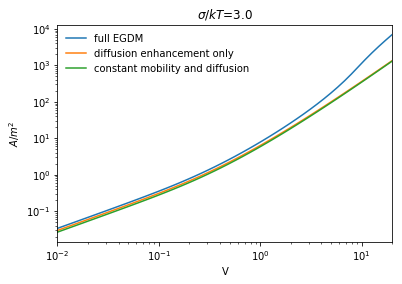

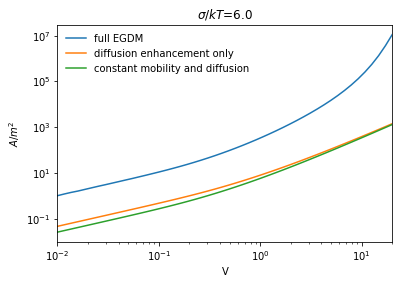

In [3]:
voltages = 10**np.linspace(-2, np.log(20) / np.log(10), 50)
for nsigma in [3., 6.]:
    for level, label in [('full_egdm', 'full EGDM'),
                         ('diffusion_egdm', 'diffusion enhancement only'),
                         ('no_egdm', 'constant mobility and diffusion')]:
        ivcurve(make_model(100e-9, level=level), nsigma, voltages, label=label)
    ivaxes(plt)
    plt.legend(loc=0, frameon=False)
    plt.xlim([1e-2, 20])
    plt.title('$\sigma / kT$=%s' % nsigma)
    plt.show()

## Fig. 7

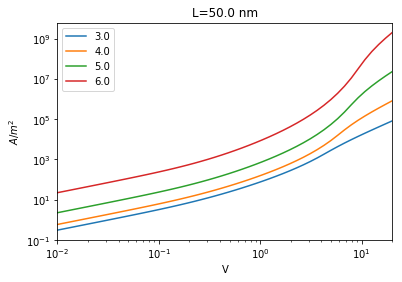

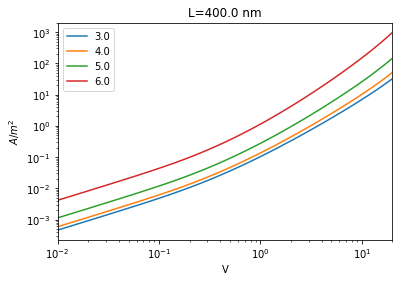

In [4]:
voltages = 10**np.linspace(-2, np.log(20) / np.log(10), 50)
for L in [ 50e-9, 400e-9 ]:
    ivcurves(L, [3., 4., 5., 6.], 10**np.linspace(-2, np.log(20) / np.log(10), 50))
    plt.title('L=%s nm' % (L * 1e9))
    plt.show()

## Fig. 9

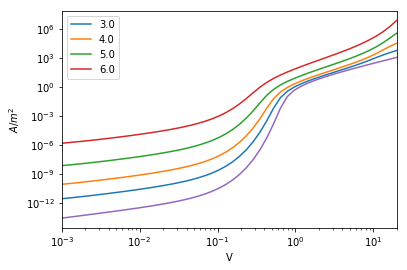

In [5]:
voltages = 10**np.linspace(np.log(1e-3) / np.log(10),
                           np.log(20) / np.log(10), 50)
ivcurves(100e-9, [3., 4., 5., 6.], voltages, Vbi=1., ifunc=ianode)
ivcurve(
    make_model(
        100e-9,
        level='no_egdm'),
    0.,
    voltages,
    Vbi=1.,
    ifunc=ianode)


---
This file is a part of __oedes__, an open source organic electronic device 
simulator. For more information, see <https://www.github.com/mzszym/oedes>.
